In [1]:
import pandas as pd
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

# Data Wrangling NHL Data Set

In [2]:
#store skater stats csv into dataframe 
game_skater_df = pd.read_csv("data/game_skater_stats.csv.zip")
player_info_df = pd.read_csv('data/player_info copy.csv')

game_info_df = pd.read_csv('data/game.csv.zip')

#store team info csv into dataframe
team_info_df = pd.read_csv('data/team_info copy.csv')
new_team_df = team_info_df[['team_id', 'shortName']]

#create new dataframe with select columms 
new_game_skater_df = game_skater_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', ]].copy()
skater_df = new_game_skater_df.drop_duplicates()

#add fantasy points to skater_df
skater_df['fantasy_points'] = (skater_df['assists']*8 + skater_df['goals']*12 + skater_df['shots']*1.6 + skater_df['blocked']*1.6 + skater_df['powerPlayGoals']*0.5 + skater_df['powerPlayAssists']*0.5 + skater_df['shortHandedGoals']*2 + skater_df['shortHandedAssists']*2)
skater_df.fillna(0)
skater_df = skater_df.reset_index(drop=True)

df1 = skater_df.merge(player_info_df, how='left', left_on='player_id', right_on='player_id')
df2 = df1.merge(game_info_df, on='game_id')
df3 = df2.merge(new_team_df, on ='team_id')
df3.head()

df4 = df3[['game_id', 'player_id', 'team_id', 'type', 'season', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points', 'shortName','firstName', 'lastName',]]

df5 = df4.sort_values(by='season', ascending = True)

#filter for last 6 regular seasons
filter_list = [20142015, 20152016, 20162017, 20172018, 20182019, 20192020]
filter_type = ['R']

new_skater_df = df5[df5.season.isin(filter_list)]
new_skater_df.reset_index(drop=True, inplace=True)
new_skater_df.head()
final_df = new_skater_df.drop_duplicates()
final_df = final_df[final_df.type.isin(filter_type)]
final_df.head()

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName
0,2014020382,8476207,29,R,20142015,876,0,0,1,0.0,0,0,0,0,1.6,Columbus,Brian,Gibbons
1,2014020346,8471873,14,R,20142015,1234,1,0,1,0.0,0,0,0,0,9.6,Tampa Bay,Anton,Stralman
2,2014020547,8470230,6,R,20142015,602,0,0,0,0.0,0,0,0,0,0.0,Boston,Daniel,Paille
3,2014020346,8470047,14,R,20142015,1201,0,0,3,0.0,0,0,0,0,4.8,Tampa Bay,Valtteri,Filppula
4,2014020547,8475414,6,R,20142015,589,0,0,1,0.0,0,0,0,0,1.6,Boston,Craig,Cunningham


In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263718 entries, 0 to 375892
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   game_id             263718 non-null  int64  
 1   player_id           263718 non-null  int64  
 2   team_id             263718 non-null  int64  
 3   type                263718 non-null  object 
 4   season              263718 non-null  int64  
 5   timeOnIce           263718 non-null  int64  
 6   assists             263718 non-null  int64  
 7   goals               263718 non-null  int64  
 8   shots               263718 non-null  int64  
 9   blocked             263718 non-null  float64
 10  powerPlayGoals      263718 non-null  int64  
 11  powerPlayAssists    263718 non-null  int64  
 12  shortHandedGoals    263718 non-null  int64  
 13  shortHandedAssists  263718 non-null  int64  
 14  fantasy_points      263718 non-null  float64
 15  shortName           263718 non-nul

In [24]:
filter_2020 = [20192020]
df_2020 =  final_df[final_df.season.isin(filter_2020)]
df_2020 = df_2020[df_2020.type.isin(filter_type)]
df_2020

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName
288991,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,0,0,0,0,3.2,Winnipeg,Josh,Morrissey
288992,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,0,0,0,0,3.2,Winnipeg,Tucker,Poolman
288993,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,0,0,0,0,6.4,Winnipeg,Luca,Sbisa
288995,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,0,0,0,0,19.2,Winnipeg,Patrik,Laine
288998,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,0,0,0,0,4.8,Winnipeg,Anthony,Bitetto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375884,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,0,0,0,0,1.6,Edmonton,James,Neal
375887,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,0,0,0,0,3.2,Edmonton,Jujhar,Khaira
375888,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,0,0,0,0,9.6,Edmonton,Adam,Larsson
375890,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,0,0,0,0,3.2,Edmonton,Josh,Archibald


In [5]:
#goalie stats csv into dataframe
goalie_stats_df = pd.read_csv("data/game_goalie_stats.csv.zip")
goalie_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
0,2016020045,8473607,4,1504,0,0,0,16,12,1,0,11,0,13,3,NaN,75.000000,33.333333,84.615385
1,2016020045,8473461,4,2011,0,0,0,11,9,1,0,8,0,10,1,L,81.818182,100.000000,80.000000
2,2016020045,8470645,16,3598,0,0,0,27,23,2,0,21,0,23,4,W,85.185185,50.000000,91.304348
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.000000,96.428571
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.000000,88.888889


In [6]:
## select goalie stats df
new_goalie_df = goalie_stats_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'savePercentage','decision']]

#add goals against column
new_goalie_df['goals_against'] = new_goalie_df['shots'] - new_goalie_df['saves']
goalie_df1 = new_goalie_df.drop_duplicates()
goalie_df = goalie_df1.fillna(0)

#add shutout and win columns
goalie_df['shutout'] = np.where((goalie_df['goals_against'] == 0) & (goalie_df['decision']!= 0), 1, 0)
goalie_df['win'] = np.where((goalie_df['decision']== 'W'), 1, 0)


#add fantasy points column to goalie df
goalie_df['fantasy_points'] = (goalie_df['goals']*12 + goalie_df['assists']*8 + goalie_df['saves']*0.8 + goalie_df['shutout']*8 + goalie_df['goals_against']*-4 + goalie_df['win']*12)
goalie_df

df_1 = goalie_df.merge(player_info_df, how='left', left_on='player_id', right_on='player_id')
df_2 = df_1.merge(game_info_df, on='game_id')
df_3 = df_2.merge(new_team_df, on ='team_id')
df_3.head()

df_4 = df_3[['game_id', 'player_id', 'team_id', 'type', 'season', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'savePercentage', 'decision', 'fantasy_points', 'shortName','firstName', 'lastName',]]

df_5 = df_4.sort_values(by='season', ascending = True)

#filter for last 6 seasons
filter_list = [20142015, 20152016, 20162017, 20172018, 20182019, 20192020]
filter_type = ['R']

goalie_df = df_5[df_5.season.isin(filter_list)]
goalie_df.reset_index(drop=True, inplace=True)
goalie_df.head()
new_goalie_df = goalie_df[goalie_df.type.isin(filter_type)]
new_goalie_df.head()

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,saves,savePercentage,decision,fantasy_points,shortName,firstName,lastName
0,2014020686,8475622,18,R,20142015,3846,0,0,27,25,92.592593,L,12.0,Nashville,Carter,Hutton
1,2014020207,8473461,4,R,20142015,3600,0,0,39,36,92.307692,W,28.8,Philadelphia,Steve,Mason
2,2014020602,8471469,18,R,20142015,3615,0,0,20,18,90.000000,W,18.4,Nashville,Pekka,Rinne
3,2014020466,8470140,25,R,20142015,3589,0,0,27,27,100.000000,W,41.6,Dallas,Kari,Lehtonen
4,2014020303,8470140,25,R,20142015,3600,1,0,41,37,90.243902,W,33.6,Dallas,Kari,Lehtonen


In [7]:
#store player info csv into dataframe 
player_info_df = pd.read_csv('data/player_info copy.csv')
player_info_df.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [8]:
#store team info csv into dataframe
team_info_df = pd.read_csv('data/team_info copy.csv')
new_team_df = team_info_df[['team_id', 'shortName']]
new_team_df.head(5)

,team_id,shortName
0,1,New Jersey
1,4,Philadelphia
2,26,Los Angeles
3,14,Tampa Bay
4,6,Boston


In [9]:
#create new dataframe with select columms
new_player_info_df = player_info_df [['player_id', 'firstName', 'lastName', 'nationality']].copy()
new_player_info_df.head()


,player_id,firstName,lastName,nationality
0,8466148,Marian,Hossa,SVK
1,8465058,Michal,Rozsival,CZE
2,8476906,Shayne,Gostisbehere,USA
3,8466285,Brian,Campbell,CAN
4,8470607,Brent,Seabrook,CAN


In [10]:
# store game info csv into a dataframe
game_info_df = pd.read_csv('data/game.csv.zip')


In [11]:
# creat new dataframe with select columns
new_game_info_df = game_info_df [['game_id', 'season', 'date_time_GMT', 'home_team_id', 'home_goals', 'outcome']].copy()
new_game_info_df.head()

,game_id,season,date_time_GMT,home_team_id,home_goals,outcome
0,2016020045,20162017,2016-10-19T00:30:00Z,16,7,home win REG
1,2017020812,20172018,2018-02-07T00:00:00Z,7,3,away win OT
2,2015020314,20152016,2015-11-24T01:00:00Z,52,1,away win REG
3,2015020849,20152016,2016-02-17T00:00:00Z,12,2,home win REG
4,2017020586,20172018,2017-12-30T03:00:00Z,24,2,home win REG


In [12]:
# cleaning new game info dataframe
cleaned_game_info = new_game_info_df[~new_game_info_df['season'].isin(['20142015', '20152016','20162017','20172018','20182019','20192020'])]
cleaned_game_info.head()

,game_id,season,date_time_GMT,home_team_id,home_goals,outcome
4961,2013020674,20132014,2014-01-11T03:00:00Z,23,2,home win REG
4962,2013020177,20132014,2013-10-29T23:00:00Z,4,2,away win REG
4963,2012020225,20122013,2013-02-19T03:00:00Z,24,3,home win REG
4964,2012020577,20122013,2013-04-08T23:00:00Z,6,6,home win REG
4965,2013021085,20132014,2014-03-25T23:30:00Z,29,4,home win REG


# Data Analysis of Previous NHL Seasons Data

In [25]:
#Top fantasy points scorers last 6 seasons


top_df = final_df.reset_index().groupby("player_id").sum()
top_df = top_df[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points']]
top_df = top_df.sort_values(by=['fantasy_points'], ascending=False)

df = top_df.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)
df.head(50)

# Top 25 skaters 14/15-19/20 seasons
top = df[['firstName', 'lastName','fantasy_points']]
top.head(25)




,firstName,lastName,fantasy_points
0,Alex,Ovechkin,8619.7
1,Patrick,Kane,7981.7
2,Brent,Burns,7862.7
3,Nikita,Kucherov,7643.3
4,Tyler,Seguin,7430.5
5,John,Tavares,7320.2
6,Nathan,MacKinnon,7230.3
7,Sidney,Crosby,7194.8
8,Blake,Wheeler,7157.7
9,Brad,Marchand,6861.1


In [26]:
# Top 25 skaters from previous 19/20 season 

top_2020 = df_2020.reset_index().groupby("player_id").sum()
top_2020 = top_2020[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points']]
top_2020 = top_2020.sort_values(by=['fantasy_points'], ascending=False)

top_2020_df = top_2020.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)


# Top 25 skaters 14/15-19/20 seasons
top_2020_df = top_2020_df[['firstName', 'lastName','fantasy_points']]
top_2020_df.head(25)

,firstName,lastName,fantasy_points
0,Nathan,MacKinnon,1510.9
1,David,Pastrnak,1475.0
2,Leon,Draisaitl,1453.2
3,Auston,Matthews,1400.5
4,Connor,McDavid,1301.5
5,Alex,Ovechkin,1298.6
6,Patrick,Kane,1285.9
7,Artemi,Panarin,1263.2
8,Nikita,Kucherov,1228.5
9,Jack,Eichel,1213.9


# Machine Learning Models 



## Linear Regression

In [15]:
def clean_dataset(skater_df):
    assert isinstance(df, skater_df.DataFrame), "df needs to be a pd.DataFrame"
    skater_df.dropna(inplace=True)
    indices_to_keep = ~skater_df.isin([np.nan, np.inf, -np.inf]).any(1)
    return skater_df[indices_to_keep].astype(np.float64)

In [16]:
pd.isnull(skater_df).sum() > 0

game_id               False
player_id             False
team_id               False
timeOnIce             False
assists               False
goals                 False
shots                 False
blocked                True
powerPlayGoals        False
powerPlayAssists      False
shortHandedGoals      False
shortHandedAssists    False
fantasy_points         True
dtype: bool

In [17]:
skater_df = skater_df.dropna(how='any',axis=0)

In [18]:

x = skater_df['timeOnIce'].values.reshape(-1,1)
y = skater_df['fantasy_points'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
regressor = LinearRegression()

#training the algorithm
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

model_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted' : y_pred.flatten()})
model_df.head()

,Actual,Predicted
0,3.2,10.967906
1,3.2,11.917271
2,6.4,9.969856
3,1.6,10.862421
4,4.8,8.906892


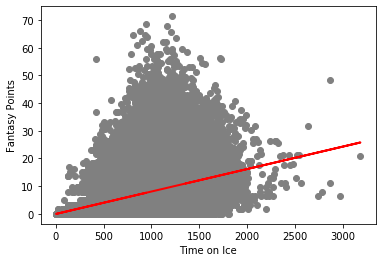

In [19]:
plt.scatter(x_test, y_test, color='gray')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('Time on Ice')
plt.ylabel('Fantasy Points')
plt.show()

# XGBoost Model

## Format Data - Split Data into Dependent and Independent Variables 

In [20]:
# X - data we will use to make classifactions and predict y

X = final_df.drop('fantasy_points', axis=1).copy()
X.head()

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shortName,firstName,lastName
0,2014020382,8476207,29,R,20142015,876,0,0,1,0.0,0,0,0,0,Columbus,Brian,Gibbons
1,2014020346,8471873,14,R,20142015,1234,1,0,1,0.0,0,0,0,0,Tampa Bay,Anton,Stralman
2,2014020547,8470230,6,R,20142015,602,0,0,0,0.0,0,0,0,0,Boston,Daniel,Paille
3,2014020346,8470047,14,R,20142015,1201,0,0,3,0.0,0,0,0,0,Tampa Bay,Valtteri,Filppula
4,2014020547,8475414,6,R,20142015,589,0,0,1,0.0,0,0,0,0,Boston,Craig,Cunningham


In [21]:
X.dtypes


game_id                 int64
player_id               int64
team_id                 int64
type                   object
season                  int64
timeOnIce               int64
assists                 int64
goals                   int64
shots                   int64
blocked               float64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
shortName              object
firstName              object
lastName               object
dtype: object

### One-Hot Encoding 

In [22]:
# we need to encode all categorical values into continuous data 

X_encoded = pd.get_dummies(X, columns=['type',
                                       'shortName',
                                       'firstName',
                                       'lastName'])
X_encoded.head()

,game_id,player_id,team_id,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,...,lastName_Zibanejad,lastName_Zidlicky,lastName_Zolnierczyk,lastName_Zubrus,lastName_Zuccarello,lastName_Zucker,lastName_Zykov,lastName_de Haan,lastName_de la Rose,lastName_van Riemsdyk
0,2014020382,8476207,29,20142015,876,0,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014020346,8471873,14,20142015,1234,1,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014020547,8470230,6,20142015,602,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014020346,8470047,14,20142015,1201,0,0,3,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014020547,8475414,6,20142015,589,0,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
y = final_df['fantasy_points'].copy()
y.head()

0    1.6
1    9.6
2    0.0
3    4.8
4    1.6
Name: fantasy_points, dtype: float64